In [29]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 

large_bedroom = create_room(6, 7)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'north', position = 0.3)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'south', position = 0.5)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'east', position = 0.1)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'north', position = 0.8)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'south', position = 0.2)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'west', position = 0.5)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'east', position = 0.6)
large_bedroom.draw()


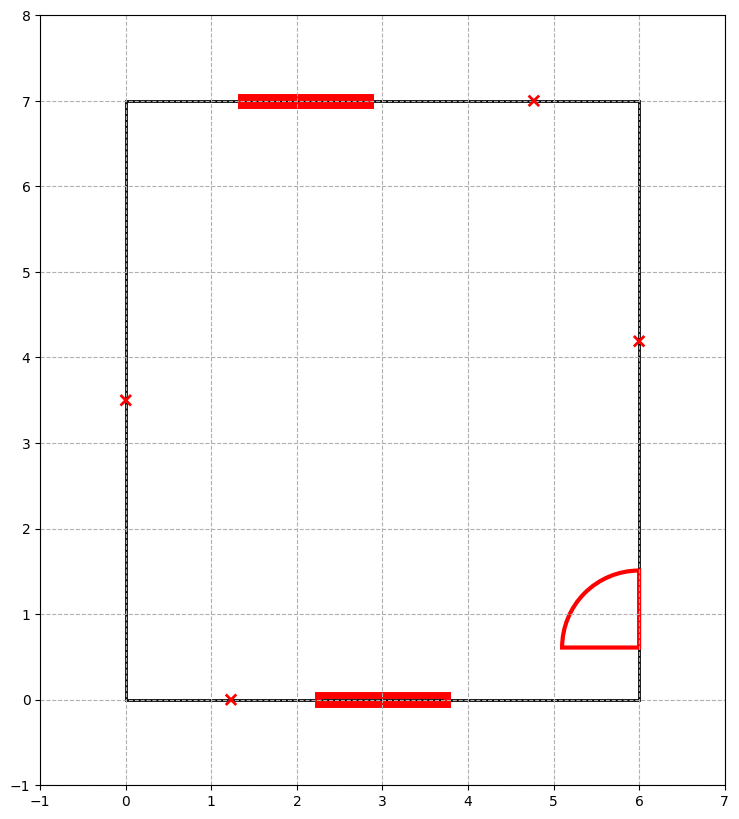

In [14]:
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
# If you're setting the API key directly in your script, uncomment the next line 

def room_setup(scene_descriptor, api_key=api_key):
    url = 'https://api.openai.com/v1/chat/completions'
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json',
            }
    
    # Read the contents of the .py file
    file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
    with open(file_path, 'r') as file:
        file_contents = file.read()

    prompt1 = "I am designing the layout for" + scene_descriptor + ". Please give me the dimensions of the room,"
    prompt1 += " as well as the number of windows, doors, and socket. For each window, door, and socket tell me the dimensions (in meters),"
    prompt1 += " which wall it should be on, as well as where on the wall it should be (this is a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: "
    prompt1 += "{Room: width = 5,  length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}, etc." 
    prompt1 += "The windows and doors should all have length 0.1. Ensure that every object has dimensions, position, and wall. "
    prompt1 += "No other text please. Just the list with no commentary or explanation."
    response1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt1}],
        max_tokens=500
    )
    objects = response1.choices[0].message.content.split("}, {")

    prompt2 = f"I am going to give you a set of functions that are used to create a room and put objects in it. The functions are as follows:"
    prompt2 += "\n\n{file_contents}\n\n"
    prompt2 += f"I now want, for each element in this list: {objects}, with room descriptor:" + scene_descriptor + ", for you to translate it into a function call using the functions I gave you above."
    prompt2 += " For example, given the room descriptor 'a small kitchen' as well as the list: "
    prompt2 += "{Room: width = 5,  length = 6}, {Object type: window, Number: 1,  width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:"
    prompt2 += "kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3), kitchen.draw()."
    prompt2 += " Return only the python script. No other text. Please ensure the correct number of inputs are given for each function. The code should end with '.draw()'."
    prompt2 += file_contents

    # Define the request payload
    data = {
        "model": "gpt-4",
        "messages": [
            {"role": "user", "content": prompt2}
        ]
    }
    
    # Make the API call
    response2 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response2.status_code == 200:
        response_data2 = response2.json()
        print(response_data2['choices'][0]['message']['content'])
        exec(response_data2['choices'][0]['message']['content'])
    else:
        print('Failed to get a response')
        print(response2.text)

    #exec(response_data2['choices'][0]['message']['content'])

    return response1, response2

#scene_descriptor = 'a bedroom for a teenager. The room is 4 meters wide and 6 meters long. There is one big window, 1 door, and 2 electrical plugs. The door should be on the far corner of the south wall.'   
scene_descriptor = "a large bedroom for a couple."
response1, response2 = room_setup(scene_descriptor)

In [15]:
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
        }

# Read the contents of the .py file
file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
with open(file_path, 'r') as file:
    file_contents = file.read()

prompt3 = "Interior designers suggest that rooms should have distinct regions in them for different functions. Given the description:"
prompt3 += scene_descriptor
prompt3 += ", what regions should this room have? Pick a reasonable number of these for this room (ensure that the most important are included)"
prompt3 += " and return them in a simple list. For example if the scene description was 'An open plan kitchen dining room', the output would be "
prompt3 += "'cooking region, dining region, cleaning region' etc. Please give no other text."

response3 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt3}],
        max_tokens=500
    )

print(response3.choices[0].message.content)

prompt4 = "For each region in the room described as: " + scene_descriptor + "with regions: " + response3.choices[0].message.content + ", give me all of the constraints/considerations on its position within the room."
prompt4 += " These constraints should depend on the physical features of the room like the windows, doors, plugs, etc."
prompt4 += " They should also depend on the other regions. For example, the constraints might be something like"
prompt4 += " 'the cooking region should be near the dining region' or 'the sleeping region should have a plug in it'"
prompt4 += " or 'the storage region should be against a wall'. Also, if there should be a focal point in the room, decide which region should include the focal point and add that as a constraint. There are many options. Return a list of these, and keep each"
prompt4 += " constraint/consideration short and simple, but make sure that you include all of the necessary considerations for"
prompt4 += " functionality as well as any design princples you think are important. Give no other text, only the list. Remove any reasoning"
prompt4 += " or explanation for the constraint/consideration. Instead of 'Sleeping region should be near an electrical plug for a bedside lamp or charging devices'"
prompt4 += " just say 'Sleeping region should be near a plug'."

response4 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt4}],
        max_tokens=500
    )

prompt5 = "Given the room so far: " + response2.json()['choices'][0]['message']['content'] + ", and the regions: " + response3.choices[0].message.content
prompt5 += " Using the functions in the script, initialise each region. For example 'eating region' might output 'eating_region = region_setup(kitchen, 'eating', 0)."
prompt5 += " End with something like kitchen.draw(draw_regions = True). No other text please, only the python script."
prompt5 += file_contents
 # Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt5}
            ]
    }
    
# Make the API call
response5 = requests.post(url, headers=headers, json=data)  
# Check the response
if response5.status_code == 200:
    response_data5 = response5.json()
    print(response2.json()['choices'][0]['message']['content'] + '\n' + response_data5['choices'][0]['message']['content'])
    #exec(response2.json()['choices'][0]['message']['content'] + '\n' + response_data5['choices'][0]['message']['content'])
else:
    print('Failed to get a response')
    print(response5.text)

Sleeping region, dressing region, sitting/reading region, storage/closet region.
large_bedroom = create_room(6, 7)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'north', position = 0.3)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'south', position = 0.5)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'east', position = 0.1)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'north', position = 0.8)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'south', position = 0.2)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'west', position = 0.5)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'east', position = 0.6)
large_bedroom.draw()
sleeping_region = region_setup(large_bedroom, 'sleeping', 0)
dressing_region = region_setup(large_bedroom, 'dressing', 1)
sitting_reading_region = region_setup(large_bedroom, 'sitting/reading', 2)
storage_closet_region = region_setup(large_bedroom, 'storage/closet', 3)
large_bedroom.draw(draw_regions = True)

large_bedroom = create_room(6, 7)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'north', position = 0.3)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'south', position = 0.5)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'east', position = 0.1)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'north', position = 0.8)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'south', position = 0.2)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'west', position = 0.5)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'east', position = 0.6)
large_bedroom.draw()
sleeping_region = region_setup(large_bedroom, 'sleeping', 0)
dressing_region = region_setup(large_bedroom, 'dressing', 1)
sitting_reading_region = region_setup(large_bedroom, 'sitting/reading', 2)
storage_closet_region = region_setup(large_bedroom, 'storage/closet', 3)
large_bedroom.draw(draw_regions = True)

positions = np.zeros(2*len(large_bedroom.regions)) 
for i in range(len(large_be

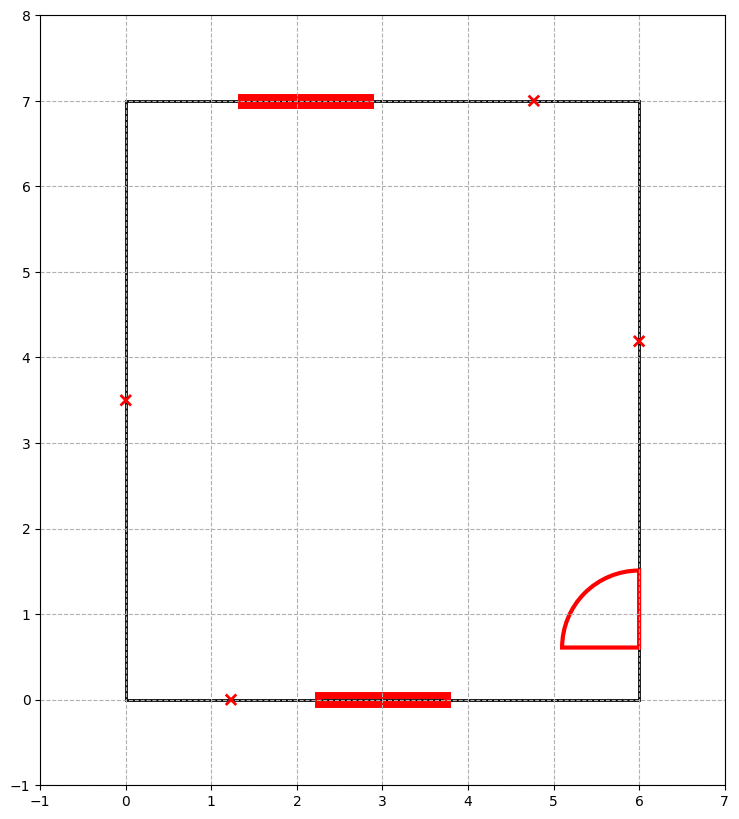

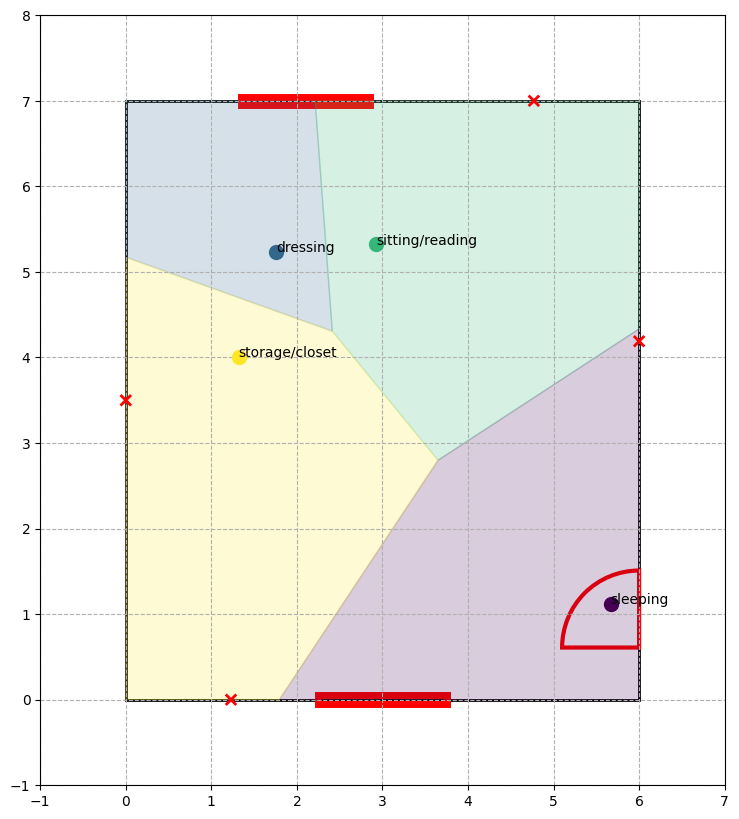

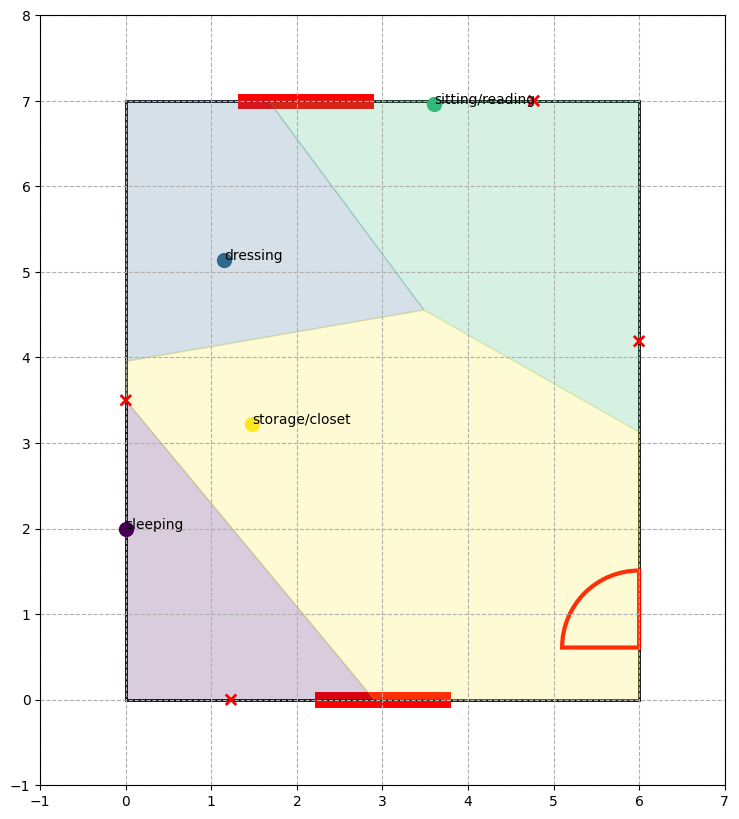

In [16]:
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
         }
# Read the contents of the .py file
file_path2 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Region.py'
with open(file_path2, 'r') as file:
    file_contents2 = file.read()


prompt6 = "Given the room set up so far: " + response2.json()['choices'][0]['message']['content'] + '\n' + response_data5['choices'][0]['message']['content']
prompt6 += ", and the regions: " + response3.choices[0].message.content + " and the constraints: " + response4.choices[0].message.content
prompt6 += " . Using the script attached, transform each constraint into a function call that will ensure that the regions are set up correctly. Match each constraint"
prompt6 += " to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out."
prompt6 += file_contents2
prompt6 += ". Then, once each point has been transformed to a function call, I then want the output to begin with the room set up, followed by: "
prompt6 += "positions = np.zeros(2*len(room.regions)) \n for i in range(len(room.regions)): \n positions[2*(room.regions[i].index)] = room.regions[i].x"
prompt6 +=  "\n positions[2*(room.regions[i].index) + 1] = room.regions[i].y (where 'room' is replaced by whatever the room name is)"
prompt6 += "\n def optimize_regions(positions, room): \n output = 0, followed by each constraint added to the ouput, and then the output returned."
prompt6 += "Finally, add this at the end (replacing 'room' with the name of the room): "
prompt6 += "bounds = Bounds([0] * 2 * len(room.regions), [room.width, room.length] * len(room.regions)) \n"
prompt6 += "res = minimize(optimize_regions, positions, args = (room), method = 'Nelder-Mead', bounds=bounds) \n"
prompt6 += "for i in range(len(room.regions)): \n room.regions[i].x, room.regions[i].y = res.x[2*(room.regions[i].index):2*(room.regions[i].index) + 2] \n"
prompt6 += "room.draw(draw_regions = True)"
prompt6 += "No extra text please, only the functions and the output. Don't have 'python' at the start of the code."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt6}
            ]
    }
    
# Make the API call
response6 = requests.post(url, headers=headers, json=data)  
# Check the response
if response6.status_code == 200:
    response_data6 = response6.json()
    print(response6.json()['choices'][0]['message']['content'])
    # Create a dictionary to hold the local context
    global_context = globals().copy()
    local_context = {}  

    # Execute the code string
    exec(response6.json()['choices'][0]['message']['content'], global_context, local_context)
    # Extract the variable 'result' from the local context
    #exec(response6.json()['choices'][0]['message']['content'])
else:
    print('Failed to get a response')
    print(response6.text)

In [17]:
room_name = (response6.json()['choices'][0]['message']['content'].split(" =")[0]).split("\n")[-1]

fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

room_width = local_context[room_name].width
room_length = local_context[room_name].length

region_names = ""
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
    else: 
        region_names += local_context[room_name].regions[i].name + "."
print(region_names)

sleeping, dressing, sitting/reading, storage/closet.


In [18]:
prompt7 = "I am going to give you a description of a room, as well as all the fixed objects inside it (e.g. windows) and the dimensions of the room."
prompt7 += " I am also going to give you the different regions for the room. Based on this information, I want returned the most important object for each region,"
prompt7 += " and the dimensions for that object in meters. This should include width and length, not height. The room description is: "
prompt7 += scene_descriptor + ", and the regions are: " + region_names + ". The fixed objects are: " + fixed_objects
prompt7 += " Finally, the room dimensions are, width : " + str(room_width) + " meters, and length : " + str(room_length) + " meters."
prompt7 += "Please return it in the format of {object_name: name, object_width: width, object_length: length, region: region_name}. After the list, I also want you to give me all the constraints for each object"
prompt7 += " that depend on the items in the room. For example if an object should have its back against a wall, or if it should be far away from a window, or near a socket. Give these as simply as possible, in the following format:  "
prompt7 += "{object_name: name, constraints: [constraint1, constraint2, ...]}. Give no other text in the response."

response7 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt7}],
        max_tokens=500
    )

print(response7.choices[0].message.content)

```json
[
    {object_name: "Bed", object_width: 2, object_length: 2, region: "sleeping"},
    {object_name: "Wardrobe", object_width: 2, object_length: 1, region: "dressing"},
    {object_name: "Armchair", object_width: 1, object_length: 1, region: "sitting/reading"},
    {object_name: "Closet", object_width: 2, object_length: 1, region: "storage/closet"}
]
```

```json
[
    {object_name: "Bed", constraints: ["back against a wall", "far from window"]},
    {object_name: "Wardrobe", constraints: ["against a wall", "near an accessible area"]},
    {object_name: "Armchair", constraints: ["near a window", "near a socket"]},
    {object_name: "Closet", constraints: ["against a wall", "far from windows and door"]}
]
```


```python
large_bedroom = create_room(6, 7)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'north', position = 0.3)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'south', position = 0.5)
create_fixed_object(large_bedroom, 'door', 0.9, 0.1, 'east', position = 0.1)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'north', position = 0.8)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'south', position = 0.2)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'west', position = 0.5)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.1, 'east', position = 0.6)
large_bedroom.draw()
sleeping_region = region_setup(large_bedroom, 'sleeping', 0)
dressing_region = region_setup(large_bedroom, 'dressing', 1)
sitting_reading_region = region_setup(large_bedroom, 'sitting/reading', 2)
storage_closet_region = region_setup(large_bedroom, 'storage/closet', 3)
large_bedroom.draw(draw_regions = True)

positions = np.zeros(2*len(large_bedroom.regions)) 
for i in range(le

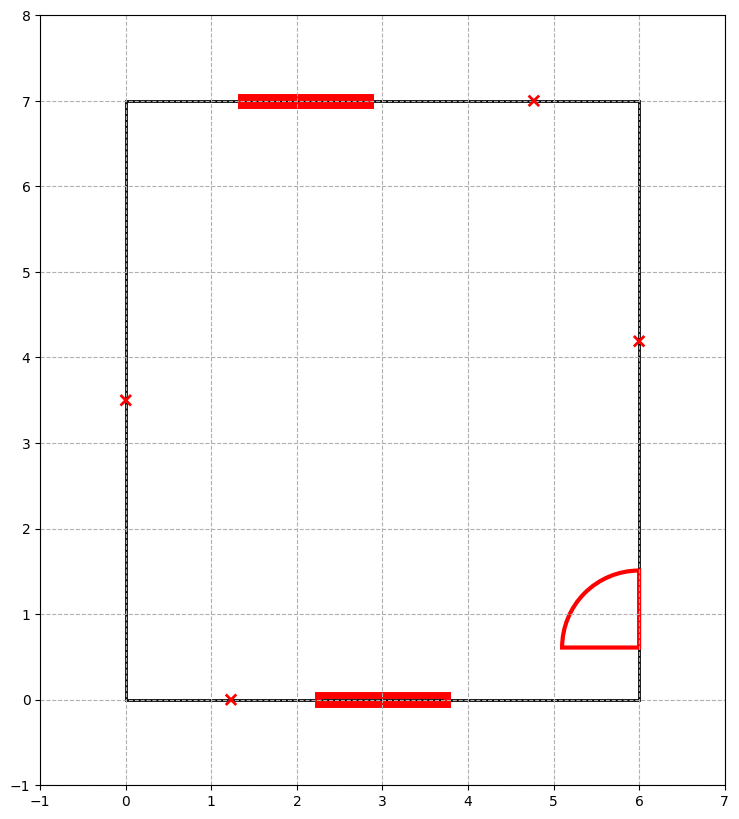

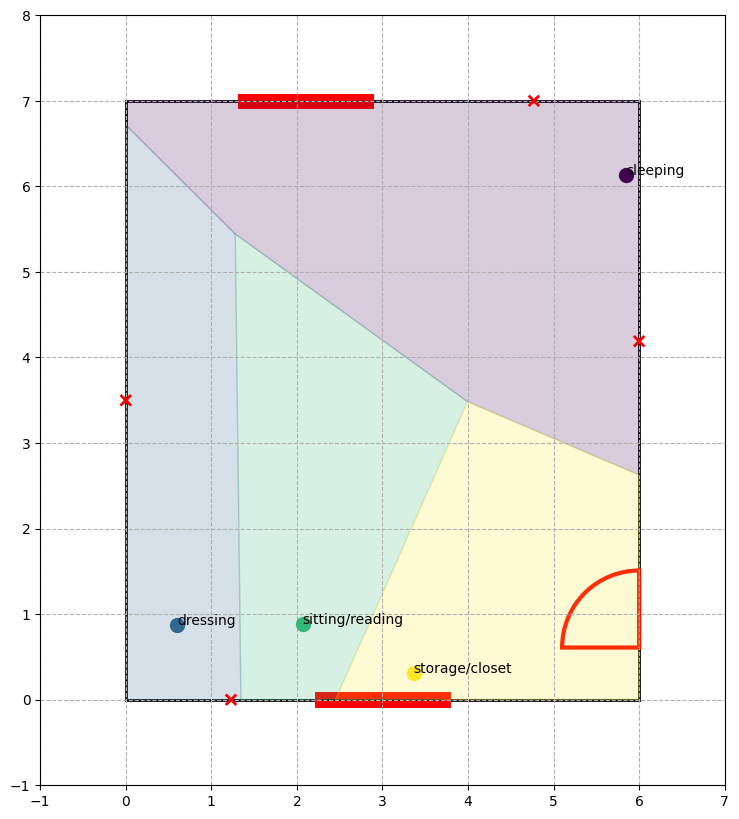

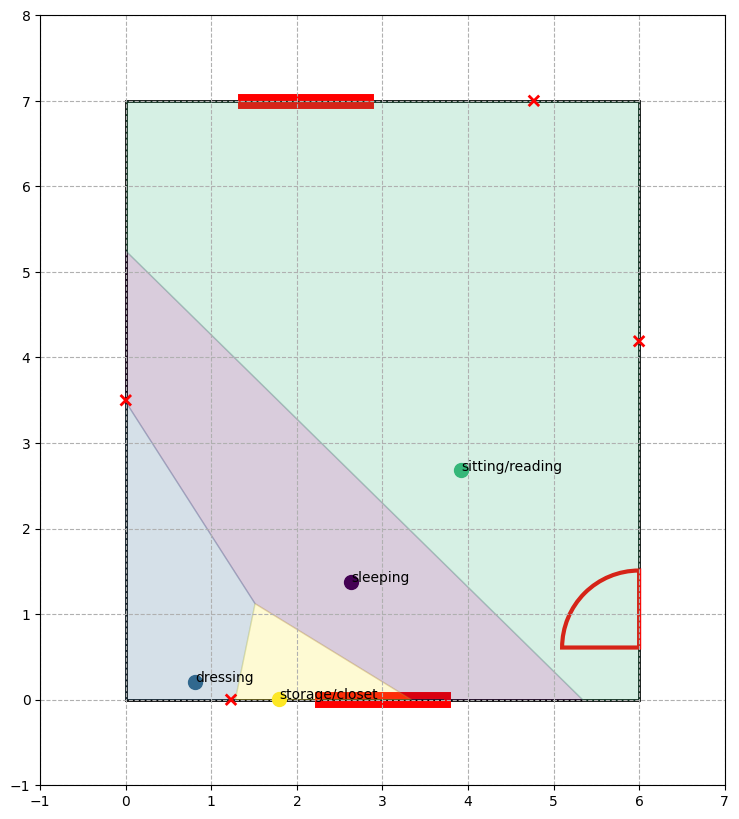

Bed [[1.63317478 0.37581511]
 [3.63317478 0.37581511]
 [3.63317478 2.37581511]
 [1.63317478 2.37581511]]
Wardrobe [[-0.18750669 -0.2908961 ]
 [ 1.81249331 -0.2908961 ]
 [ 1.81249331  0.7091039 ]
 [-0.18750669  0.7091039 ]]
Wardrobe hi2
Wardrobe hi4
Armchair [[4.41589618 2.18106744]
 [4.41589618 3.18106744]
 [3.41589618 3.18106744]
 [3.41589618 2.18106744]]
Closet [[ 0.79357789 -0.49245821]
 [ 2.79357789 -0.49245821]
 [ 2.79357789  0.50754179]
 [ 0.79357789  0.50754179]]
Closet hi4


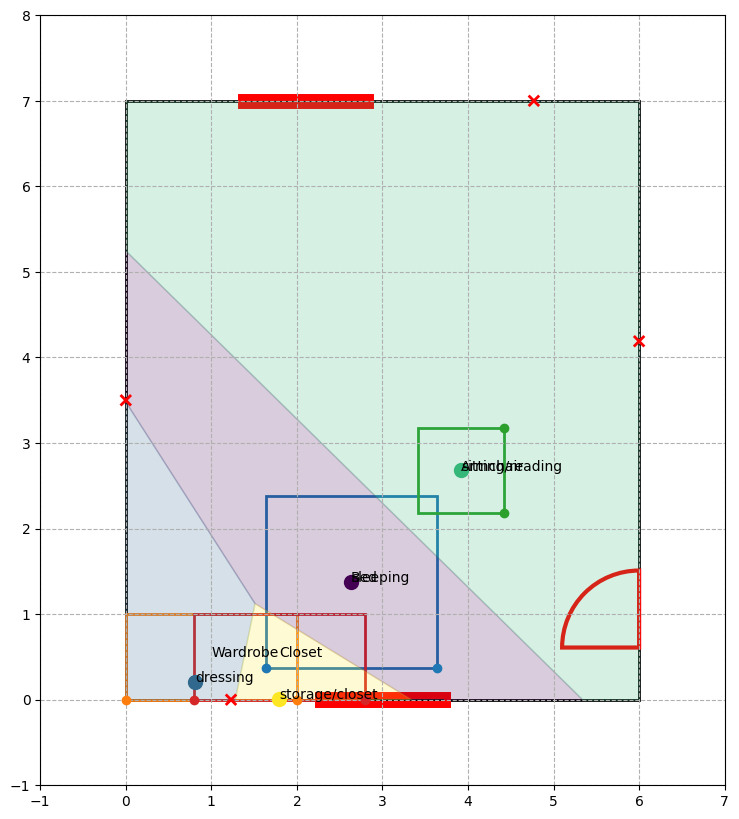

In [20]:
prompt8 = "Given this list of the objects: " + response7.choices[0].message.content.split("]")[0] + "], use the file attached (as well as the room code so far) to add the objects into the room with the correct parameters."
prompt8 += "The room code so far is: " + response6.json()['choices'][0]['message']['content']
prompt8 += "This should not be edited at all, it should be the start of the output exactly as is. The region names are as follows: " + region_names
prompt8 += "The objects should be added in the correct regions. The code should end with 'room.draw(draw_regions = True)'."
prompt8 += "This is the file: " + file_contents
prompt8 += "No extra text, only the functions and the output. Don't have 'python' at the start of the code."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt8}
            ]
    }
    
# Make the API call
response8 = requests.post(url, headers=headers, json=data)  
# Check the response
if response8.status_code == 200:
    response_data8 = response8.json()
    print(response8.json()['choices'][0]['message']['content'])
    if "```python" in response8.json()['choices'][0]['message']['content']:
        response8 = (response8.json()['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        exec(response8)
    else:
        response8 = response8.json()['choices'][0]['message']['content']
        exec(response8)
else:
    print('Failed to get a response')
    print(response8.text)

```python
positions = np.zeros(3*len(large_bedroom.moving_objects)) 
for i in range(len(large_bedroom.moving_objects)): 
    positions[3*i] = large_bedroom.moving_objects[i].position[0]
    positions[3*i + 1] = large_bedroom.moving_objects[i].position[1] 
    positions[3*i + 2] = large_bedroom.moving_objects[i].position[2]

def optimize_primary_objects(positions, large_bedroom): 
    output = 0
    
    output += next_to_wall(positions, large_bedroom, 0, side='back')
    output += object_away_from_fixed_object(positions, large_bedroom, 0, 'window')
    output += next_to_wall(positions, large_bedroom, 1)
    output += accessible(positions, large_bedroom, 1, sides=['front'])
    output += object_close_to_fixed_object(positions, large_bedroom, 2, 'window')
    output += object_close_to_fixed_object(positions, large_bedroom, 2, 'socket')
    output += next_to_wall(positions, large_bedroom, 3)
    output += object_away_from_fixed_object(positions, large_bedroom, 3, 'window')
    output += o

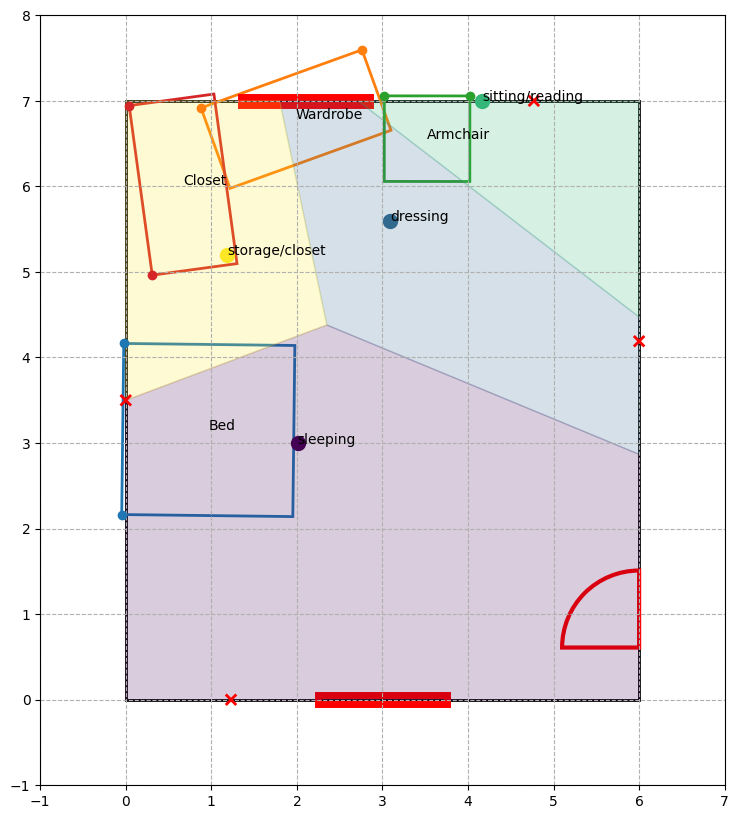

In [28]:
# Read the contents of the .py file
file_path3 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Individual.py'
with open(file_path3, 'r') as file:
    file_contents3 = file.read()


prompt9 = "Given the room set up so far: " + response8
prompt9 += ", as well as the primary objects and their constraints: " + response7.choices[0].message.content
prompt9 += " . Using the script attached, transform each constraint into a function call that will ensure that the primary objects are set up correctly. Match each constraint"
prompt9 += " to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out."
prompt9 += file_contents3
prompt9 += ". Then, once each point has been transformed to a function call, I then want the output to begin with the room set up, followed by: "
prompt9 += "positions = np.zeros(3*len(room.moving_objects)) \n for i in range(len(room.moving_objects)): \n positions[3*i] = room.moving_objects[i].position[0]\n"
prompt9 += "positions[3*i + 1] = room.moving_objects[i].position[1] \n positions[3*i + 2] = room.moving_objects[i].position[2] (where 'room' is replaced by whatever the room name is)"
prompt9 += "\n def optimize_primary_objects(positions, room): \n output = 0, followed by each constraint added to the ouput, and then the output returned."
prompt9 += "Finally, add this at the end (replacing 'room' with the name of the room): "
prompt9 += "bounds = Bounds([0] * 3 * len(room.moving_objects), [room.width, room.length, 2*np.pi] * len(room.moving_objects))\n"
prompt9 += "res = minimize(optimize_primary_objects, positions, args = (room), method = 'Nelder-Mead', bounds=bounds) \n  for i in range(len(room.moving_objects)): \n"
prompt9 += "room.moving_objects[i].position = res.x[3*i:3*i + 3] \n room.draw(draw_regions= True)"
prompt9 += "No extra text please, only the functions and the output. Don't have 'python' at the start of the code."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt9}
            ]
    }
    
# Make the API call
response9 = requests.post(url, headers=headers, json=data)  
# Check the response
if response9.status_code == 200:
    response_data9 = response9.json()
    print(response9.json()['choices'][0]['message']['content'])
    if "```python" in response9.json()['choices'][0]['message']['content']:
        response9 = (response9.json()['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        exec(response9)

    else:
        response9 = response9.json()['choices'][0]['message']['content']
        exec(response9)
else:
    print('Failed to get a response')
    print(response9.text)

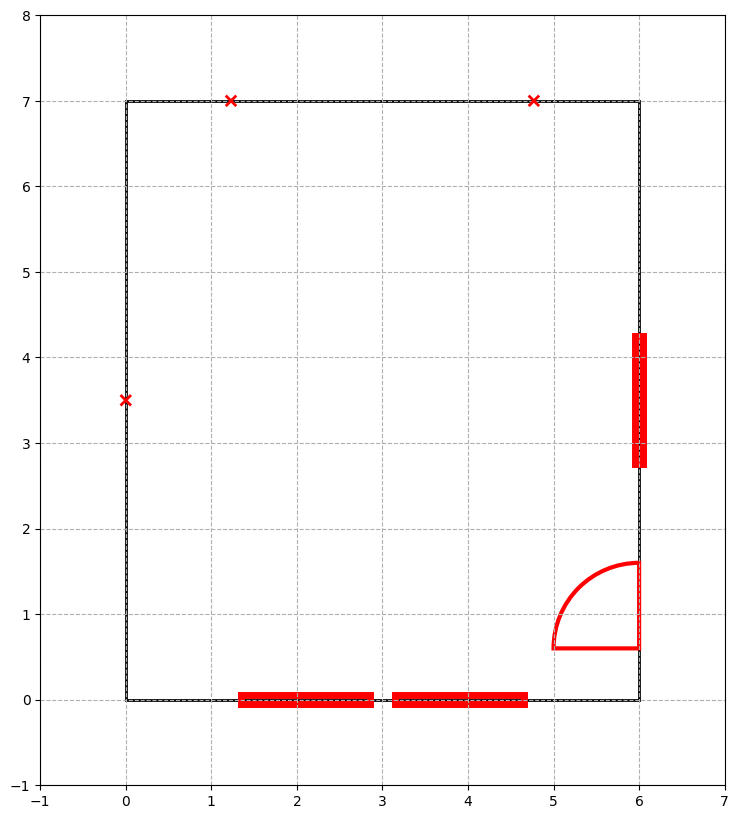

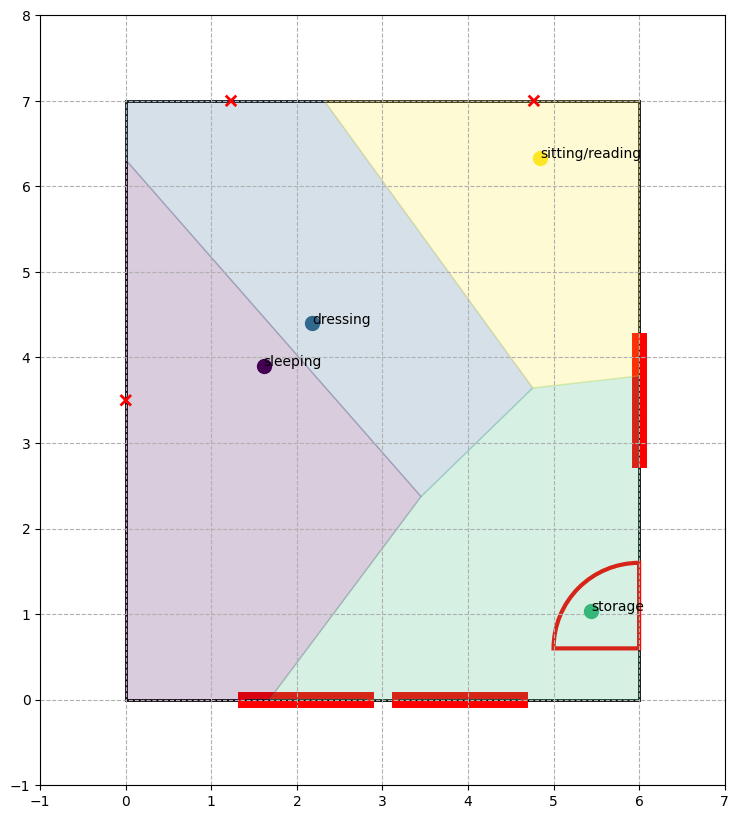

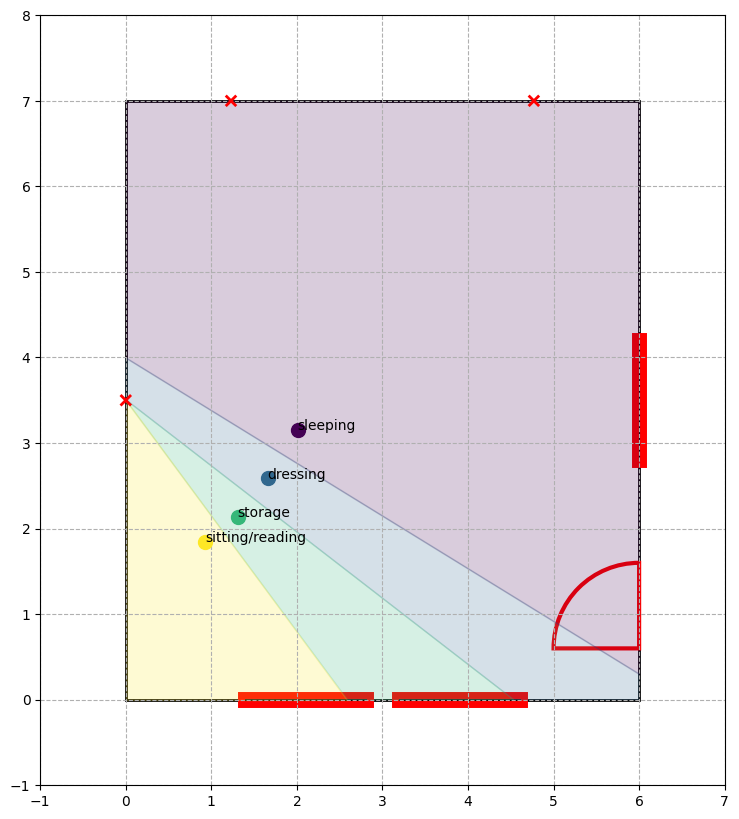

bed [[1.00811886 4.15329881]
 [1.00811886 2.15329881]
 [3.00811886 2.15329881]
 [3.00811886 4.15329881]]
wardrobe [[1.35854867 3.58580606]
 [1.35854867 1.58580606]
 [1.95854867 1.58580606]
 [1.95854867 3.58580606]]
dresser [[1.05875833 2.88356813]
 [1.05875833 1.38356813]
 [1.55875833 1.38356813]
 [1.55875833 2.88356813]]
armchair [[0.52472572 2.24928296]
 [0.52472572 1.44928296]
 [1.32472572 1.44928296]
 [1.32472572 2.24928296]]


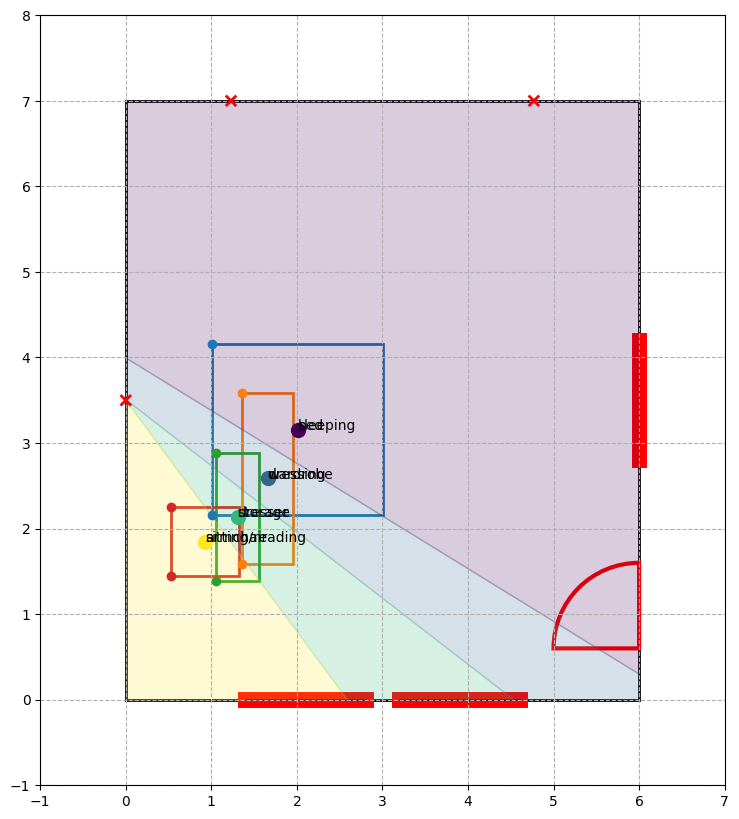

No region with this name is in the room.


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [12]:
room = create_room(6, 7)
create_fixed_object(room, 'window', 1.5, 0.1, 'south', position = 0.3)
create_fixed_object(room, 'window', 1.5, 0.1, 'south', position = 0.7)
create_fixed_object(room, 'window', 1.5, 0.1, 'east', position = 0.5)
create_fixed_object(room, 'door', 1, 0.1, 'east', position = 0.1)
create_fixed_object(room, 'socket', 0.1, 0.1, 'north', position = 0.2)
create_fixed_object(room, 'socket', 0.1, 0.1, 'north', position = 0.8)
create_fixed_object(room, 'socket', 0.1, 0.1, 'west', position = 0.5)
room.draw()

sleeping_region = region_setup(room, 'sleeping', 0)
dressing_region = region_setup(room, 'dressing', 1)
storage_region = region_setup(room, 'storage', 2)
sitting_reading_region = region_setup(room, 'sitting/reading', 3)
room.draw(draw_regions = True)

positions = np.zeros(2*len(room.regions)) 
for i in range(len(room.regions)): 
    positions[2*(room.regions[i].index)] = room.regions[i].x
    positions[2*(room.regions[i].index) + 1] = room.regions[i].y

def optimize_regions(positions, room): 
    output = 0
    output += close_to_fixed_object(positions, room, 'sleeping', 'socket')
    output += away_from_fixed_object(positions, room, 'sleeping', 'door')
    output += close_to(positions, room, 'sleeping', 'dressing')
    output += close_to(positions, room, 'dressing', 'storage')
    output += away_from_fixed_object(positions, room, 'dressing', 'window')
    output += close_to_wall(positions, room, 'storage')
    output += close_to(positions, room, 'storage', 'dressing')
    output += close_to_fixed_object(positions, room, 'sitting/reading', 'window')
    output += close_to_fixed_object(positions, room, 'sitting/reading', 'socket')
    output += away_from(positions, room, 'sitting/reading', 'sleeping')
    output += include_focal_point(positions, room, 'sitting/reading')
    output += distinct_regions(positions, room)
    return output

bounds = Bounds([0] * 2 * len(room.regions), [room.width, room.length] * len(room.regions)) 
res = minimize(optimize_regions, positions, args = (room), method = 'Nelder-Mead', bounds=bounds) 
for i in range(len(room.regions)): 
    room.regions[i].x, room.regions[i].y = res.x[2*(room.regions[i].index):2*(room.regions[i].index) + 2] 
room.draw(draw_regions = True)

create_moving_object(room, 'bed', 2, 2, 'sleeping', index=0)
create_moving_object(room, 'wardrobe', 2, 0.6, 'dressing', index=1)
create_moving_object(room, 'dresser', 1.5, 0.5, 'storage', index=2)
create_moving_object(room, 'armchair', 0.8, 0.8, 'sitting/reading', index=3)

room.draw(draw_regions = True)

positions = np.zeros(3*len(room.moving_objects)) 
for i in range(len(room.moving_objects)): 
    positions[3*i] = room.moving_objects[i].position[0]
    positions[3*i + 1] = room.moving_objects[i].position[1] 
    positions[3*i + 2] = room.moving_objects[i].position[2]

def optimize_primary_objects(positions, room): 
    output = 0
    output += close_to_fixed_object(positions, room, 0, 'socket')
    output += away_from_fixed_object(positions, room, 0, 'window')
    output += in_region(positions, room, 0, 'sleeping')
    output += in_region(positions, room, 1, 'dressing')
    output += in_region(positions, room, 2, 'storage')
    output += in_region(positions, room, 3, 'sitting/reading')
    output += no_overlap(positions, room)
    output += in_bounds(positions, room)
    return output

bounds = Bounds([0] * 3 * len(room.moving_objects), [room.width, room.length, 2*np.pi] * len(room.moving_objects))
res = minimize(optimize_primary_objects, positions, args = (room), method = 'Nelder-Mead', bounds=bounds) 
for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = res.x[3*i:3*i + 3] 
room.draw(draw_regions= True)

[1.07773975e+00 3.30900553e+00 4.77874674e+00 3.70000157e+00
 2.74989746e+00 1.57079611e+00 2.00024687e-01 5.00004868e-01
 3.17942362e-05 3.08210913e-01 4.52010148e+00 4.74101680e+00]


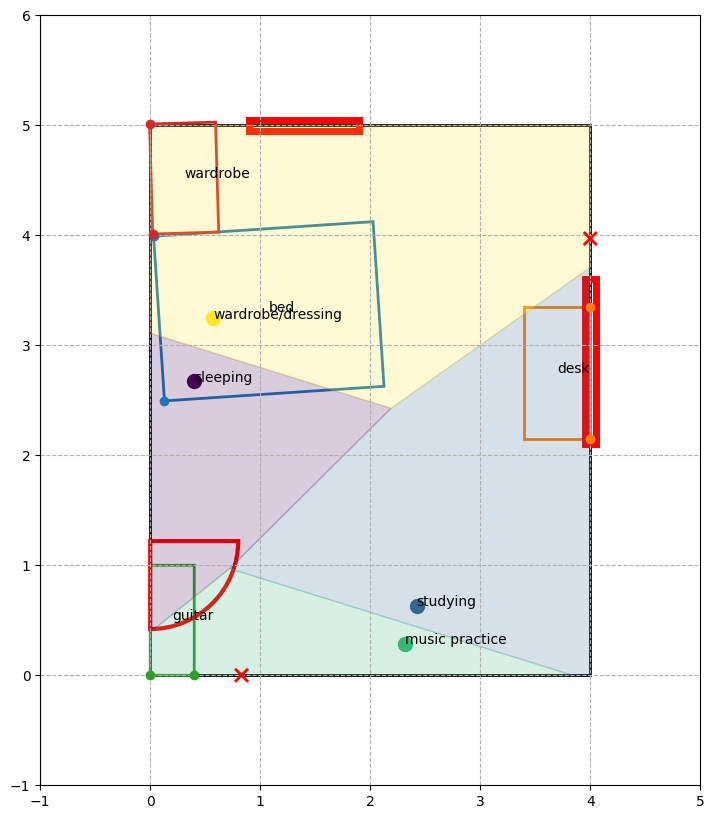

In [54]:
import Individual as ind

positions = np.zeros(3*len(room.moving_objects))
for i in range(len(room.moving_objects)):
    positions[3*i] = room.moving_objects[i].position[0]
    positions[3*i + 1] = room.moving_objects[i].position[1]
    positions[3*i + 2] = room.moving_objects[i].position[2]

def optimize_primary_objects(positions, room):
    
    output = 0
    output += ind.next_to_wall(positions, room, 0, side = 'back')
    output += ind.next_to_wall(positions, room, 1, side = 'back')
    output += ind.next_to_wall(positions, room, 2, side = 'back')
    output += ind.next_to_wall(positions, room, 3, side = 'back')
    output += 5*ind.in_bounds(positions, room)
    output += ind.away_from_fixed_object(positions, room, 0, 'window')
    output += ind.away_from_fixed_object(positions, room, 0, 'door')
    #output += ind.close_to_fixed_object(positions, room, 0, 'socket')
    output += ind.close_to_fixed_object(positions, room, 1, 'window')
    #output += ind.close_to_fixed_object(positions, room, 1, 'socket')

    output += 2*ind.in_region(positions, room, 0, 'sleeping')
    output += 2*ind.in_region(positions, room, 1, 'studying')
    output += 2*ind.in_region(positions, room, 2, 'music practice')
    output += 2*ind.in_region(positions, room, 3, 'wardrobe/dressing')

    output += 5*ind.no_overlap(positions, room)

    # print("")
    #print(ind.next_to_wall(positions, room, 0, side = 'back'), ind.away_from_fixed_object(positions, room, 0, 'window'), ind.away_from_fixed_object(positions, room, 0, 'door'), ind.close_to_fixed_object(positions, room, 0, 'socket'), ind.in_region(positions, room, 0, 'sleeping'))
    # print(ind.next_to_wall(positions, room, 1, side = 'back'), ind.close_to_fixed_object(positions, room, 1, 'window'), ind.close_to_fixed_object(positions, room, 1, 'socket'))
    # print(ind.next_to_wall(positions, room, 2, side = 'back'), ind.in_region(positions, room, 2, 'music practice'))
    # print(ind.next_to_wall(positions, room, 3, side = 'back'), ind.in_region(positions, room, 3, 'wardrobe/dressing'))
    return output

bounds = Bounds([0] * 3 * len(room.moving_objects), [room.width, room.length, 2*np.pi] * len(room.moving_objects))
res = minimize(optimize_primary_objects, positions, args = (room), method = 'Nelder-Mead', bounds=bounds)
for i in range(len(room.moving_objects)):
    room.moving_objects[i].position = res.x[3*i:3*i + 3]
room.draw(draw_regions= True)

In [14]:
response7 = """[
    {object_name: bed, object_width: 1.5, object_length: 2, region: sleeping},
    {object_name: desk, object_width: 1.2, object_length: 0.6, region: studying},
    {object_name: guitar, object_width: 0.4, object_length: 1, region: music practice},
    {object_name: wardrobe, object_width: 1, object_length: 0.6, region: wardrobe/dressing}
]

[
    {object_name: bed, constraints: [back against wall, far away from window]},
    {object_name: desk, constraints: [near socket, back against wall]},
    {object_name: guitar, constraints: [near socket, far away from window]},
    {object_name: wardrobe, constraints: [back against wall]}
]"""

In [44]:
# Prompt to get the optimisation functions for the positions of the objects
prompt9

NameError: name 'prompt9' is not defined

2.999999999999999
0.5999999999999999
0.4643677171718219


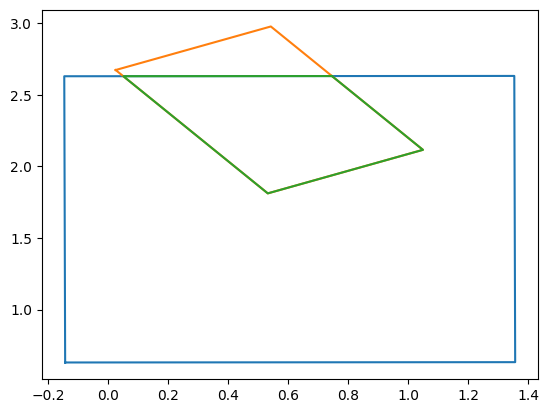

In [15]:
from shapely.geometry import Polygon
bed = room.find('bed')
wardrobe = room.find('wardrobe')

poly1 = Polygon([bed.TL(), bed.TR(), bed.BR(), bed.BL()])
poly2 = Polygon([wardrobe.TL(), wardrobe.TR(), wardrobe.BR(), wardrobe.BL()])
intersection = poly1.intersection(poly2)
print(poly1.area)
print(poly2.area)
print(intersection.area)

x,y = poly1.exterior.xy
x2,y2 = poly2.exterior.xy
x3, y3 = intersection.exterior.xy
plt.plot(x,y)
plt.plot(x2, y2)
plt.plot(x3, y3)

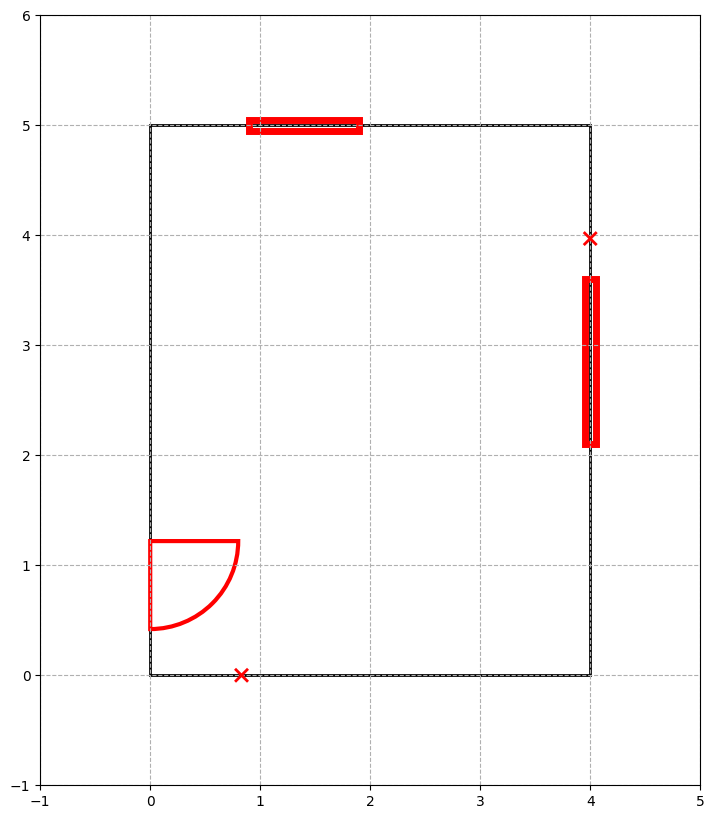

In [47]:
room.moving_objects = []
room.draw()

